# Variability analysis for HBECs

In [1]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from pybedtools import BedTool
import pickle as pkl
%matplotlib inline
import itertools

import statsmodels.formula.api as smf
import statsmodels.api as sm
pd.set_option('display.max_rows', 600)

In [2]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq')
import encode
import memento

In [3]:
data_path = '/data_volume/memento/hbec/'
# fig_path = '/data/home/Github/scrna-parameter-estimation/figures/fig6/'

In [4]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [5]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)

### Read ISG classes

In [21]:
isg_classes = pd.read_csv('../isg_classes2.csv')
t1_isg = isg_classes.query('overall_type =="type1"').gene.tolist()
t2_isg = isg_classes.query('overall_type =="type2"').gene.tolist()
shared_isg = isg_classes.query('overall_type == "shared"').gene.tolist()
all_isg = isg_classes[isg_classes.sum(axis=1) > 0].gene.tolist()

/tmp/ipykernel_18533/3798624070.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  all_isg = isg_classes[isg_classes.sum(axis=1) > 0].gene.tolist()


In [22]:
len(all_isg)

762

### Read CHIP-seq data

In [8]:
enc = encode.Encode('/home/ssm-user/Github/misc-seq/miscseq/GRCh38Genes.bed')

In [9]:
stat1_bed = enc.get_encode_peaks_union([
    'https://www.encodeproject.org/files/ENCFF747ICD/@@download/ENCFF747ICD.bed.gz',
    'https://www.encodeproject.org/files/ENCFF646MXG/@@download/ENCFF646MXG.bed.gz'
])
stat2_bed = enc.get_encode_peaks_union([
    'https://www.encodeproject.org/files/ENCFF204VQS/@@download/ENCFF204VQS.bed.gz',
    'https://www.encodeproject.org/files/ENCFF545JVD/@@download/ENCFF545JVD.bed.gz'
])

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/ssm-user/anaconda3/envs/single_cell/lib/python

In [10]:
intersect_bed = stat1_bed.intersect(stat2_bed).sort()

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)


In [11]:
isgf3_genes = enc.get_peak_genes_bed(intersect_bed, 0).query('distance == 0 & ~gene.str.contains("MT").values').gene.tolist()

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pybedtools/bedtool.py:3678: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file 

### Read 1D HT results

In [13]:
cts = ['C', 'B', 'BC', 'all_ct']
tps = [ '3', '6', '9', '24', '48']
stims = ['alpha', 'beta', 'gamma', 'lambda']

In [13]:
def read_result():
    
    ht_dict = {}
    moments_dict = {}
    
    for stim in stims:
        adata_subset = sc.read(data_path + '/binary_test_latest/C_{}_3.h5ad'.format(stim))
        ht_dict[stim] = memento.get_1d_ht_result(adata_subset)
        ht_dict[stim]['de_fdr'] = memento.util._fdrcorrect(ht_dict[stim]['de_pval'])
        ht_dict[stim]['dv_fdr'] = memento.util._fdrcorrect(ht_dict[stim]['dv_pval'])
        ht_dict[stim]= ht_dict[stim][(ht_dict[stim]['de_coef'].abs() < 100) & (ht_dict[stim]['dv_coef'].abs() < 100)]
#         moments_dict[stim] = memento.get_1d_moments(adata_subset, groupby='stim_indicator')
    return ht_dict,moments_dict

In [14]:
ht, moments = read_result()

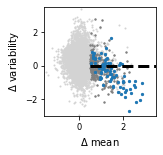

In [42]:
plt.figure(figsize=(2, 2))
plt.scatter(ht['beta']['de_coef'], ht['beta']['dv_coef'], s=1, color='lightgrey')
plt.scatter(
    ht['gamma'].query('gene in @shared_isg')['de_coef'], 
    ht['gamma'].query('gene in @shared_isg')['dv_coef'], s=2, color='grey')
plt.scatter(
    ht['beta'].query('gene in @isgf3_genes & de_coef > 0.5 & de_fdr < 0.05')['de_coef'], 
    ht['beta'].query('gene in @isgf3_genes & de_coef > 0.5 & de_fdr < 0.05')['dv_coef'], s=5)
plt.plot([0.5, 4], [0, 0], '--', lw=3, color='k')
plt.xlabel(r'$\Delta$ mean');plt.ylabel(r'$\Delta$ variability');
plt.ylim(-3, 3.5); plt.xlim(-1.6, 3.5)
plt.savefig('de_vs_dv_tss_beta.png', bbox_inches='tight', dpi=500)

(-1.0, 2.0)

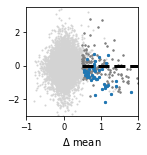

In [43]:
plt.figure(figsize=(2, 2))
plt.scatter(ht['gamma']['de_coef'], ht['gamma']['dv_coef'], s=1, color='lightgrey')
plt.scatter(
    ht['gamma'].query('gene in @shared_isg')['de_coef'], 
    ht['gamma'].query('gene in @shared_isg')['dv_coef'], s=2, color='grey')
plt.scatter(
    ht['gamma'].query('gene in @isgf3_genes & de_coef > 0.5 & de_fdr < 0.05')['de_coef'], 
    ht['gamma'].query('gene in @isgf3_genes & de_coef > 0.5 & de_fdr < 0.05')['dv_coef'], s=5,)

plt.plot([0.5, 3], [0, 0], '--', lw=3, color='k')
plt.xlabel(r'$\Delta$ mean');#plt.ylabel(r'$\Delta$ variability'); 
plt.savefig('de_vs_dv_tss_gamma.png', bbox_inches='tight', dpi=500)
plt.ylim(-3, 3.5); plt.xlim(-1.6, 3.5)

plt.xlim(-1, 2)

### Variability over time

In [18]:
import functools

In [19]:
tps = ['3', '6', '9', '24', '48']

In [26]:
ct = 'C'
all_tp_ht = []
for tp in tps:
    ht = [
        memento.get_1d_ht_result(
            sc.read(data_path + 'binary_test_latest/{}_{}_{}.h5ad'.format(ct, stim, tp)))\
            .rename(columns={'dv_coef':'lfc_{}_{}'.format(stim, tp)})[['gene', 'lfc_{}_{}'.format(stim,tp)]] \
        for stim in ['beta']]
    lfc = functools.reduce( lambda x,y: x.merge(y, on='gene'), ht,).query('gene in @all_isg')
    all_tp_ht.append(lfc)

In [27]:
all_tp_ht = functools.reduce( lambda x,y: x.merge(y, on='gene'), all_tp_ht)

In [49]:
all_tp_ht['increasing'] = all_tp_ht.apply(lambda row: stats.pearsonr(np.arange(5), row.iloc[1:6])[0], axis=1)
all_tp_ht['increasing'] = all_tp_ht['lfc_beta_48'] - all_tp_ht['lfc_beta_3']

In [72]:
all_tp_ht.query('gene == "CXCL10"')

,gene,lfc_beta_3,lfc_beta_6,lfc_beta_9,lfc_beta_24,lfc_beta_48,increasing
162,CXCL10,2.406248,2.310029,2.335257,2.747541,2.161789,-0.244458


In [71]:
all_tp_ht.sort_values('increasing').tail(20)

,gene,lfc_beta_3,lfc_beta_6,lfc_beta_9,lfc_beta_24,lfc_beta_48,increasing
648,MX1,-1.880321,-1.797503,-1.392978,-1.120591,-1.033780,0.846541
308,PRNCR1,0.293224,0.852778,0.708605,-0.392307,1.186740,0.893516
459,RNF31,-0.023837,-0.263799,0.597457,0.335139,0.897984,0.921820
382,TRIM5,-0.478316,-0.502150,0.309775,-0.292319,0.465455,0.943771
309,DENND3,-1.270507,-1.436133,-0.670210,-0.749618,-0.324573,0.945935
568,RNF213,-1.155217,-1.063557,-0.450297,-0.444140,-0.207769,0.947448
28,IFI44L,-2.738668,-2.753924,-2.107204,-2.052014,-1.780415,0.958253
230,PSMB8-AS1,-0.483825,0.010554,0.091550,0.697776,0.480743,0.964568
73,RAB29,-0.853689,-0.810197,0.471186,0.097888,0.195892,1.049581
205,HIST1H1C,-0.549644,-0.145520,-0.091748,-0.104019,0.602188,1.151833


### Variability UMAP

PARP6

In [6]:
ct = 'BC'
stim = 'beta'

In [7]:
adata = sc.read(data_path + 'HBEC_type_I_processed_deep.h5ad')

In [8]:
converter = {'basal/club':'BC', 'basal':'B', 'ciliated':'C', 'goblet':'G', 'ionocyte/tuft':'IT', 'neuroendo':'N', 'club':'club'}

In [9]:
adata.obs['ct'] = adata.obs['cell_type'].apply(lambda x: converter[x])
# adata_processed.obs['ct'] = adata_processed.obs['cell_type'].apply(lambda x: converter[x])

1.6736808371543854
1.6736808371543854
1.6736808371543854
1.6736808371543854
1.6736808371543854


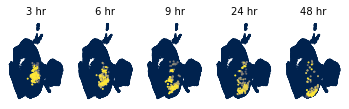

In [82]:
tps = ['3', '6', '9', '24', '48']
plt.figure(figsize=(6,1.5))

for idx, tp in enumerate(tps):
    plt.subplot(1, 5, idx+1)
    X_umap = adata.obsm['X_umap']
    expr = np.exp(adata.raw[:, 'PARP6'].X.todense().A1)-1
#     expr = adata.raw[:, 'CXCL10'].X.todense().A1
    stim = adata.obs.stim == 'beta'
    time = adata.obs.time == tp
    ct = adata.obs.ct == 'BC'
    combined = expr * stim * time * ct
    
    adata.obs['intensity'] = combined
    adata.obs['is_time'] = (time*ct*stim).astype(int)
    order = np.argsort(combined)#[time*ct*stim]
    plt.scatter(X_umap[order, 0], X_umap[order, 1], s=1, c=combined[order], cmap='cividis', vmax=1.5)
    plt.axis('off'); #plt.xlim(-5, 5); plt.ylim(-7, 1); 
    plt.title('{} hr'.format(tp))
    print(np.quantile(expr, 0.99))
    plt.savefig('parp6_umaps.png', bbox_inches='tight', dpi=1000)

3.6853432130813553
3.6853432130813553
3.6853432130813553
3.6853432130813553
3.6853432130813553


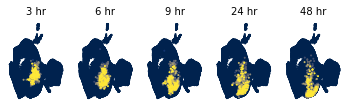

In [81]:
tps = ['3', '6', '9', '24', '48']
plt.figure(figsize=(6,1.5))

for idx, tp in enumerate(tps):
    plt.subplot(1, 5, idx+1)
    X_umap = adata.obsm['X_umap']
    expr = np.exp(adata.raw[:, 'TRIM5'].X.todense().A1)-1
#     expr = adata.raw[:, 'CXCL10'].X.todense().A1
    stim = adata.obs.stim == 'beta'
    time = adata.obs.time == tp
    ct = adata.obs.ct == 'BC'
    combined = expr * stim * time * ct
    
    adata.obs['intensity'] = combined
    adata.obs['is_time'] = (time*ct*stim).astype(int)
    order = np.argsort(combined)#[time*ct*stim]
    plt.scatter(X_umap[order, 0], X_umap[order, 1], s=1, c=combined[order], cmap='cividis', vmax=3)
    plt.axis('off'); #plt.xlim(-5, 5); plt.ylim(-7, 1); 
    plt.title('{} hr'.format(tp))
    print(np.quantile(expr, 0.99))
plt.savefig('trim5_umaps.png', bbox_inches='tight', dpi=1000)

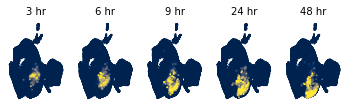

In [10]:
tps = ['3', '6', '9', '24', '48']
plt.figure(figsize=(6,1.5))

for idx, tp in enumerate(tps):
    plt.subplot(1, 5, idx+1)
    X_umap = adata.obsm['X_umap']
    expr = np.exp(adata.raw[:, 'CXCL10'].X.todense().A1)-1
#     expr = adata.raw[:, 'CXCL10'].X.todense().A1
    stim = adata.obs.stim == 'beta'
    time = adata.obs.time == tp
    ct = adata.obs.ct == 'BC'
    combined = expr * stim * time * ct
    
    adata.obs['intensity'] = combined
    adata.obs['is_time'] = (time*ct*stim).astype(int)
    order = np.argsort(combined)#[time*ct*stim]
    plt.scatter(X_umap[order, 0], X_umap[order, 1], s=1, c=combined[order], cmap='cividis', vmax=100)
    plt.axis('off'); #plt.xlim(-5, 5); plt.ylim(-7, 1); 
    plt.title('{} hr'.format(tp))
plt.savefig('cxcl10_umaps.png', bbox_inches='tight', dpi=1000)

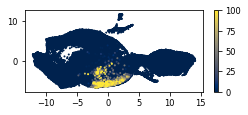

In [109]:
plt.figure(figsize=(4,1.5))
plt.scatter(X_umap[order, 0], X_umap[order, 1], s=1, c=combined[order], cmap='cividis', vmax=100)
plt.colorbar()
plt.savefig('cxcl10_cbar.png', bbox_inches='tight', dpi=1000)

In [25]:
expr = adata.raw[:, 'CXCL10'].X.todense().A1
beta_stim = adata.obs.stim == 'beta'
time = adata.obs.time == tp
ct = adata.obs.ct == 'BC'
combined = expr * beta_stim * time

In [26]:
adata.obs['intensity'] = combined

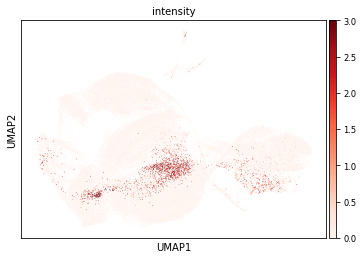

In [28]:
sc.pl.umap(adata, color='intensity', cmap='Reds', vmin=0, vmax=3)

In [28]:
converter = {'basal/club':'BC', 'basal':'B', 'ciliated':'C', 'goblet':'G', 'ionocyte/tuft':'IT', 'neuroendo':'N'}

In [29]:
adata.obs['ct'] = adata.obs['cell_type'].apply(lambda x: converter[x])
# adata_processed.obs['ct'] = adata_processed.obs['cell_type'].apply(lambda x: converter[x])

In [30]:
adata = adata[(adata.obs['ct'] == ct) & (adata.obs['stim'] == stim)].copy()

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [32]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata.raw = adata
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=40, n_pcs=40)
sc.tl.umap(adata)
